## 상품랭킹 알고리즘 

###  점포 - 역삼점 ,  중분류 - 우유  , 기간 - 21.06.01~21.06.30

In [2]:
query='''select master.PRDT_CD,master.PRDT_NM ,master.PRDT_DI_CD,master.PRDT_CAT_CD,
master.PRDT_GCODE_CD ,master.PRDT_MCODE_CD ,master.PRDT_DCODE_CD ,
sum(detail.SALE_AMT-detail.ENURI_AMT) as all_sale,sum(detail.SALE_QTY) as quantity , master.MARGIN_RATE ,detail.PROFIT_AMT,detail.UCOST_AMT
FROM `cds_core.TB_DW_RCIPT_DETAIL` as detail
join `cds_core.TB_DW_PRDT_MASTR` as master
on detail.PRDT_CD=master.PRDT_CD 
where detail.BSN_DT>='2021-06-01' and detail.BSN_DT<='2021-06-30' and master.BIZTP_CD='10' and detail.BIZTP_CD='10' and detail.AFLCO_CD='001' and master.AFLCO_CD='001'
AND detail.STR_CD BETWEEN '1000' AND '1166'AND detail.SALE_TRGT_YN = 'Y' AND detail.STR_CD='1020' and master.PRDT_MCODE_CD='0088'
group by master.PRDT_CD,master.PRDT_NM , master.PRDT_DI_CD,master.PRDT_CAT_CD,master.PRDT_GCODE_CD ,master.PRDT_MCODE_CD ,master.PRDT_DCODE_CD ,master.MARGIN_RATE
,detail.PROFIT_AMT,detail.UCOST_AMT
having all_sale>0
order by all_sale desc'''


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df=pd.read_csv(r'C:\Users\Administrator\Desktop\df.csv')

In [5]:
df['PRDT_CD'].value_counts()

8801115114611    21
8801069221397    16
8801121020968    16
8801115114154    16
8801207090830    15
                 ..
8801069406404     3
8801121024126     3
8801069412610     3
8801121772874     2
8801069302102     1
Name: PRDT_CD, Length: 67, dtype: int64


### Scenario <br><Br>Y= 총매출로 설정하고 XGBoost로 모델링 후 Gini Importance를 통해 총매출에 관련하여 어느정도의 feature importance를 가지는지 확인

In [6]:
df.head()

,PRDT_CD,PRDT_NM,PRDT_DI_CD,PRDT_CAT_CD,PRDT_GCODE_CD,PRDT_MCODE_CD,PRDT_DCODE_CD,all_sale,quantity,MARGIN_RATE,PROFIT_AMT,UCOST_AMT
0,8801069221397,남양 맛있는우유GT 2입(900ml*2),30,33,332,88,612,5069700,1310,16.71,1173,2697
1,8801115111054,서울우유 2.3L,30,33,332,88,612,3635150,667,23.96,1324,4126
2,8801115114673,서울우유 속편한 저지방 900ml*2입,30,33,332,88,617,2952810,763,27.00,1084,2786
3,8801115114154,서울우유 1L,30,33,332,88,612,1993900,785,20.33,544,1996
4,8801207090830,파스퇴르 우유 2입(930ml*2),30,33,332,88,615,1850700,310,24.00,2217,3753


In [7]:
df.count()

PRDT_CD          471
PRDT_NM          471
PRDT_DI_CD       471
PRDT_CAT_CD      471
PRDT_GCODE_CD    471
PRDT_MCODE_CD    471
PRDT_DCODE_CD    471
all_sale         471
quantity         471
MARGIN_RATE      471
PROFIT_AMT       471
UCOST_AMT        471
dtype: int64

### 사용 변수 : 판매개수 , 마진율 , 이익금액, 원가금액

In [8]:
df_new=df[['all_sale','quantity','MARGIN_RATE','PROFIT_AMT','UCOST_AMT','PRDT_NM']]

In [9]:
y=df_new['all_sale']

In [10]:
X = df_new[df_new.columns.difference(['all_sale','PRDT_NM'])]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [13]:
from xgboost import XGBRegressor

In [14]:
model_reg = XGBRegressor()
model_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<BarContainer object of 4 artists>

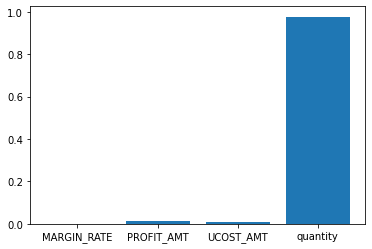

In [15]:
import matplotlib.pyplot as plt
plt.bar(X.columns, model_reg.feature_importances_)

In [16]:
list(model_reg.feature_importances_)

[0.0006034811, 0.013880213, 0.00878244, 0.97673386]

### 변수들을 활용하여 Scoring

In [17]:
df_new

,all_sale,quantity,MARGIN_RATE,PROFIT_AMT,UCOST_AMT,PRDT_NM
0,5069700,1310,16.71,1173,2697,남양 맛있는우유GT 2입(900ml*2)
1,3635150,667,23.96,1324,4126,서울우유 2.3L
2,2952810,763,27.00,1084,2786,서울우유 속편한 저지방 900ml*2입
3,1993900,785,20.33,544,1996,서울우유 1L
4,1850700,310,24.00,2217,3753,파스퇴르 우유 2입(930ml*2)
...,...,...,...,...,...,...
466,1260,1,26.39,-531,1791,남양 맛있는우유GT 900ml
467,1190,1,25.07,-366,1556,파스퇴르 후레쉬우유 3입(200ml*3)
468,1180,1,20.33,-816,1996,서울우유 1L
469,1100,1,27.49,-597,1697,서울우유 3입(200ml*3)


In [18]:
score=0.0006*df_new['MARGIN_RATE']+0.02*df_new['PROFIT_AMT']+0.008*df_new['UCOST_AMT']+0.97*df_new['quantity']

In [19]:
score

0      1315.746026
1       706.492376
2       784.094200
3       788.310198
4       375.078400
          ...     
466       4.693834
467       6.113042
468       0.630198
469       2.622494
470       1.248448
Length: 471, dtype: float64

In [20]:
df_new['score']=score

<ipython-input-20-3bd4abb0edd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['score']=score


In [21]:
df_new

,all_sale,quantity,MARGIN_RATE,PROFIT_AMT,UCOST_AMT,PRDT_NM,score
0,5069700,1310,16.71,1173,2697,남양 맛있는우유GT 2입(900ml*2),1315.746026
1,3635150,667,23.96,1324,4126,서울우유 2.3L,706.492376
2,2952810,763,27.00,1084,2786,서울우유 속편한 저지방 900ml*2입,784.094200
3,1993900,785,20.33,544,1996,서울우유 1L,788.310198
4,1850700,310,24.00,2217,3753,파스퇴르 우유 2입(930ml*2),375.078400
...,...,...,...,...,...,...,...
466,1260,1,26.39,-531,1791,남양 맛있는우유GT 900ml,4.693834
467,1190,1,25.07,-366,1556,파스퇴르 후레쉬우유 3입(200ml*3),6.113042
468,1180,1,20.33,-816,1996,서울우유 1L,0.630198
469,1100,1,27.49,-597,1697,서울우유 3입(200ml*3),2.622494


In [22]:
df_new=df_new.sort_values(by='score',ascending=False);df_new

,all_sale,quantity,MARGIN_RATE,PROFIT_AMT,UCOST_AMT,PRDT_NM,score
0,5069700,1310,16.71,1173,2697,남양 맛있는우유GT 2입(900ml*2),1315.746026
3,1993900,785,20.33,544,1996,서울우유 1L,788.310198
2,2952810,763,27.00,1084,2786,서울우유 속편한 저지방 900ml*2입,784.094200
1,3635150,667,23.96,1324,4126,서울우유 2.3L,706.492376
136,53820,9,30.00,19467,3817,덴마크 산양우유 750ml,428.624000
...,...,...,...,...,...,...,...
300,9960,4,33.01,-3324,3321,파스퇴르 소화가 잘되는 우유(700ml*2입),-36.012194
359,6080,4,26.00,-2908,2247,서울 밀크랩 고단백저지방우유 900ml,-36.288400
351,6560,4,27.99,-3176,2434,서울우유 그린라벨 1L,-40.151206
314,8680,7,31.49,-3213,1699,고칼슘 저지방 소화 잘되는 우유 900ML,-43.859106


In [23]:
df_new.reset_index(drop=True,inplace=True);df_new

,all_sale,quantity,MARGIN_RATE,PROFIT_AMT,UCOST_AMT,PRDT_NM,score
0,5069700,1310,16.71,1173,2697,남양 맛있는우유GT 2입(900ml*2),1315.746026
1,1993900,785,20.33,544,1996,서울우유 1L,788.310198
2,2952810,763,27.00,1084,2786,서울우유 속편한 저지방 900ml*2입,784.094200
3,3635150,667,23.96,1324,4126,서울우유 2.3L,706.492376
4,53820,9,30.00,19467,3817,덴마크 산양우유 750ml,428.624000
...,...,...,...,...,...,...,...
466,9960,4,33.01,-3324,3321,파스퇴르 소화가 잘되는 우유(700ml*2입),-36.012194
467,6080,4,26.00,-2908,2247,서울 밀크랩 고단백저지방우유 900ml,-36.288400
468,6560,4,27.99,-3176,2434,서울우유 그린라벨 1L,-40.151206
469,8680,7,31.49,-3213,1699,고칼슘 저지방 소화 잘되는 우유 900ML,-43.859106


In [24]:
df_new['RANK']=df_new.index+1

### 스코어에 따른 랭킹 산정

In [25]:
df_Rank=df_new[['RANK','PRDT_NM','score','all_sale']]

In [29]:
df_Rank

,RANK,PRDT_NM,score,all_sale
0,1,남양 맛있는우유GT 2입(900ml*2),1315.746026,5069700
1,2,서울우유 1L,788.310198,1993900
2,3,서울우유 속편한 저지방 900ml*2입,784.094200,2952810
3,4,서울우유 2.3L,706.492376,3635150
4,5,덴마크 산양우유 750ml,428.624000,53820
...,...,...,...,...
466,467,파스퇴르 소화가 잘되는 우유(700ml*2입),-36.012194,9960
467,468,서울 밀크랩 고단백저지방우유 900ml,-36.288400,6080
468,469,서울우유 그린라벨 1L,-40.151206,6560
469,470,고칼슘 저지방 소화 잘되는 우유 900ML,-43.859106,8680
